In [1]:
%matplotlib inline

In [53]:
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# notebook specific imports
import pickle
import copy
import utils.utils_funcs as utils
import run_functions as rf
import math
from subsets_analysis import Subsets
from scipy import signal
import random
import more_itertools as mit
from scipy.ndimage import gaussian_filter
from scipy import stats
from bisect import bisect
from sklearn.decomposition import FastICA

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [6]:
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

In [7]:
pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

In [8]:
runs[0].__dict__.keys()
# rf.raw_data_plotter(runs[0])

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'flu_raw', 'frames_ms', 'frames_ms_pre', 'flu', 'spks', 'stat'])

In [11]:
# how many frames before and after the onset of lick trial to include in the kernal
pre_frames  = 5
post_frames = 9
fs = 5  # frame rate / plane

# empirally observed that 1.4 seconds after onset the artifact has gone for 150 cell trials
# offset = math.ceil(1.4*fs)

# empirally observed that offset = 4 for non-150 cell stims
offset = 4

n_sessions = len(runs)
np.mean = np.nanmean  # lots of nans to deal with here

offset

4

In [12]:
runs = [rf.filter_unhealthy_cells(run) for run in runs]
runs_s2 = [rf.select_s2(run) for run in copy.deepcopy(runs)]
runs = [utils.lick_binner(run) for run in runs]

In [13]:
## toggle to use deconv spikes
is_spks = True
for i in range(len(runs)):
    runs[i].flu = runs[i].spks
    runs_s2[i].flu = runs_s2[i].spks


In [14]:
behaviour_list = [utils.build_flu_array(run, run.trial_start, pre_frames, post_frames)
                  for run in runs]

behaviour_list_s2 = [utils.build_flu_array(run, run.trial_start, pre_frames, post_frames)
                     for run in runs_s2]

In [15]:
assert runs[0].flu.shape[0] == behaviour_list[0].shape[0]


In [16]:
def cell_differ(cell_average, pre_frames, post_frames, offset):
    
    post = cell_average[:, pre_frames+offset : pre_frames+offset+(post_frames-offset)]
    pre  = cell_average[:, 0:pre_frames]
    return np.nanmean(post, 1) - np.nanmean(pre, 1)

In [17]:
def flat_difference(runs, array_list, pre_frames, post_frames, offset,
                    trial_outcome='all', good=True):
    
    difference = []

    for run, arr in zip(runs, array_list):

        if trial_outcome != 'all':
            trials = utils.intersect(
                     np.where((run.outcome==trial_outcome) & (Subsets(run).trial_subsets!=150))[0],
                     rf.filter_trials(run, good=good))

            arr = arr[:, trials, :]
            
        trial_mean = np.nanmean(arr, 1)
        difference.append(cell_differ(trial_mean, pre_frames, post_frames, offset))
        
    return np.concatenate(difference).ravel()

In [18]:
def correlation_plots(runs, behaviour_list, pre_frames, post_frames, offset,
                      to_corr, good=True, is_spks=False, plot=True):
    
    assert len(to_corr) == 2
    diff = [None, None]
    labels = [None, None]
    
    for i, corr in enumerate(to_corr):
        
        if corr == 'hit':
            diff[i] = flat_difference(runs, behaviour_list, pre_frames, post_frames, offset,
                                       trial_outcome='hit', good=good)
            labels[i] = 'Hit Trials'       
            
        elif corr == 'miss':
            diff[i] = flat_difference(runs, behaviour_list, pre_frames, post_frames, offset,
                                       trial_outcome='miss', good=good)
            labels[i] = 'Miss Trials'
            
        elif corr == 'spont':
            print('ere')
            spont_list = [rf.get_spont_trials(run, pre_frames, post_frames) for run in runs]
            diff[i] = flat_difference(runs, spont_list, pre_frames, post_frames, offset=0, 
                                      trial_outcome='all', good=good)
            labels[i] = 'Spontaneous "Trials"'
            
        elif corr == 'lick':
            lick_list = [utils.build_flu_array(run, run.pre_reward,
                                     pre_frames, post_frames, True)
                                     for run in runs]
            
            diff[i] = flat_difference(runs, lick_list, pre_frames, post_frames, offset=0, 
                                      trial_outcome='all', good=good)
            
            labels[i] = 'Spontaneous Rewards'
        else:
            raise ValueError
            
    nonnan_idx = np.logical_and(~np.isnan(diff[0]), ~np.isnan(diff[1]))

    x = diff[0][nonnan_idx].reshape(-1, 1)
    y = diff[1][nonnan_idx]

    model = LinearRegression()
    model.fit(x,y)
    r_sq = r2_score(x, model.predict(x))
    
    if plot:
        plt.plot(x, y, '.')

        if is_spks:
               plt.xlabel('Spks Jump (Post-Pre)\n{}'.format(labels[0]))
               plt.ylabel('Spks Jump (Post-Pre)\n{}'.format(labels[1]))
        else:
            plt.xlabel('$\Delta $F/F Jump (Post-Pre)\n{}'.format(labels[0]))
            plt.ylabel('$\Delta $F/F Jump (Post-Pre)\n{}'.format(labels[1]))
        plt.plot(x, model.predict(x), color='k')
        plt.text(np.max(x)*0.7, np.max(y)*0.7, 'r^2 = {}'.format(round(r_sq, 3)), fontsize=21)

    return diff[0], diff[1]
    

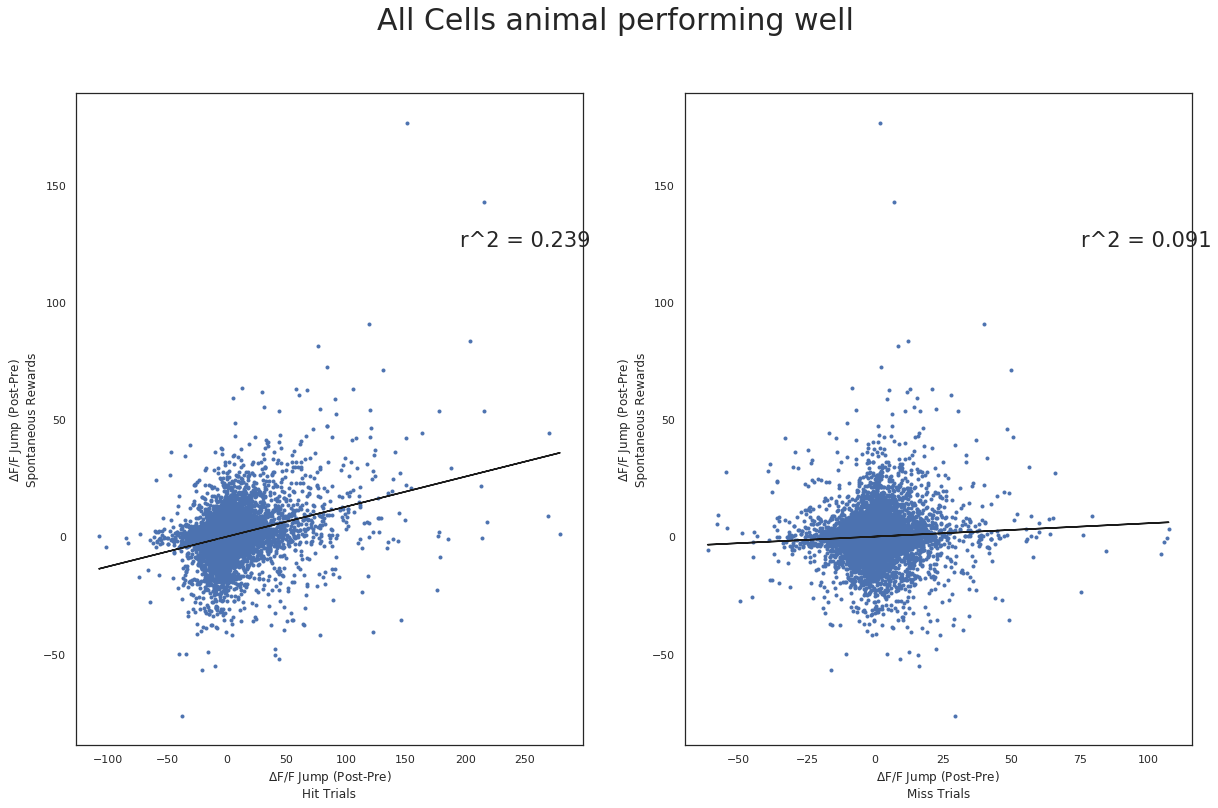

In [19]:
is_spks=False

s2 = False
good = True

# s2 = True
# good = True

# s2 = False
# good = False

# s2 = True
# good = False

### basic figure settings
plt.figure(figsize=(20, 12))

if good:
    good_label = 'animal performing well'
else:
    good_label = 'animal performing badly'

if s2:
    s2_label = 'S2 only'
else:
    s2_label = 'All Cells'

if is_spks:
    plt.suptitle('Deconvolved Spikes {} {}'.format(s2_label, good_label), fontsize=30)
else:
    plt.suptitle('{} {}'.format(s2_label, good_label), fontsize=30)

## bar plot all subsets
plt.subplot(1,2,1)
if s2:
    hit_diffs, miss_diffs = rf.subsets_diff_plotter(runs_s2, behaviour_list_s2,
                                                    pre_frames, post_frames, offset, good=good,
                                                    is_spks=is_spks)
else:
    hit_diffs, miss_diffs = rf.subsets_diff_plotter(runs, behaviour_list,
                                                    pre_frames, post_frames, offset, good=good,
                                                    is_spks=is_spks)
plt.ylim((0,0.035))

### barplot subset mean

plt.subplot(1,2,2)
plt.bar([0,1],[np.nanmean(hit_diffs), np.nanmean(miss_diffs)], 
               yerr=[np.nanstd(hit_diffs), np.nanstd(miss_diffs)], 
               color=[sns.color_palette()[0], sns.color_palette()[6]])

plt.ylim((0,0.035))
if is_spks:
    plt.ylabel(r'Mean spks Jump Post-Pre')
else:
    plt.ylabel(r'Mean $\Delta $F/F Jump Post-Pre')

plt.xticks([0,1], ['Hit Trials', 'Miss Trials'])
plt.xlabel('Average across subsets')

plt.subplot(1,2,1)

to_corr = ['hit', 'lick']

if s2:
    all_hits, all_licks = correlation_plots(runs_s2, behaviour_list_s2, pre_frames, post_frames, offset,
                                              to_corr, good=good, is_spks=is_spks)
else:
    all_hits, all_licks = correlation_plots(runs, behaviour_list, pre_frames, post_frames, offset,
                                              to_corr, good=good, is_spks=is_spks)
    
plt.subplot(1,2,2)

to_corr = ['miss', 'lick']

if s2:
    correlation_plots(runs_s2, behaviour_list_s2, pre_frames, post_frames, offset,
                        to_corr, good=good, is_spks=is_spks)
else:
    correlation_plots(runs, behaviour_list, pre_frames, post_frames, offset,
                        to_corr, good=good, is_spks=is_spks)


In [21]:
def get_idx_from_flat(runs, flat_idx):
    n_cells = np.cumsum([run.flu.shape[0] for run in runs])
    session = bisect(n_cells, flat_idx)
    if session == 0:
        cell_idx = flat_idx
    else:
        cell_idx = flat_idx - n_cells[session-1]
        
    return session, cell_idx

Text(0.5, 0, 'Time (Seconds)')

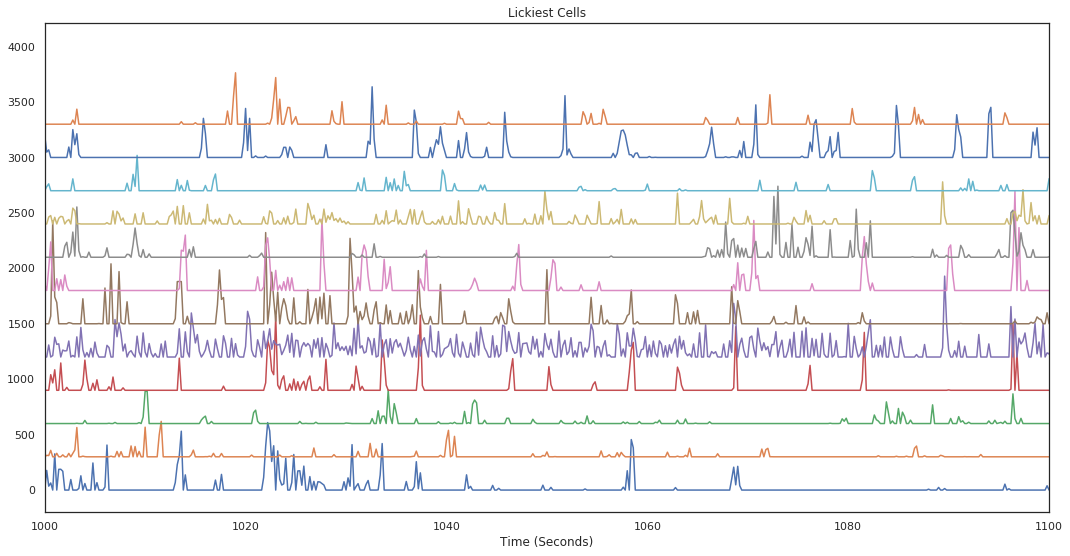

In [22]:
lick_order = np.argsort(all_licks)
lickiest = [get_idx_from_flat(runs, idx) for idx in np.flip(lick_order[-12:])]
plt.figure(figsize=(18,9))
plt.title('Lickiest Cells')

for i, cell in enumerate(lickiest): 
    x_axis = np.arange(runs[cell[0]].flu.shape[1]) / fs

    plt.plot(x_axis, runs[cell[0]].flu[cell[1], :] + i*300)
plt.xlim((1000,1100))
plt.xlabel('Time (Seconds)')

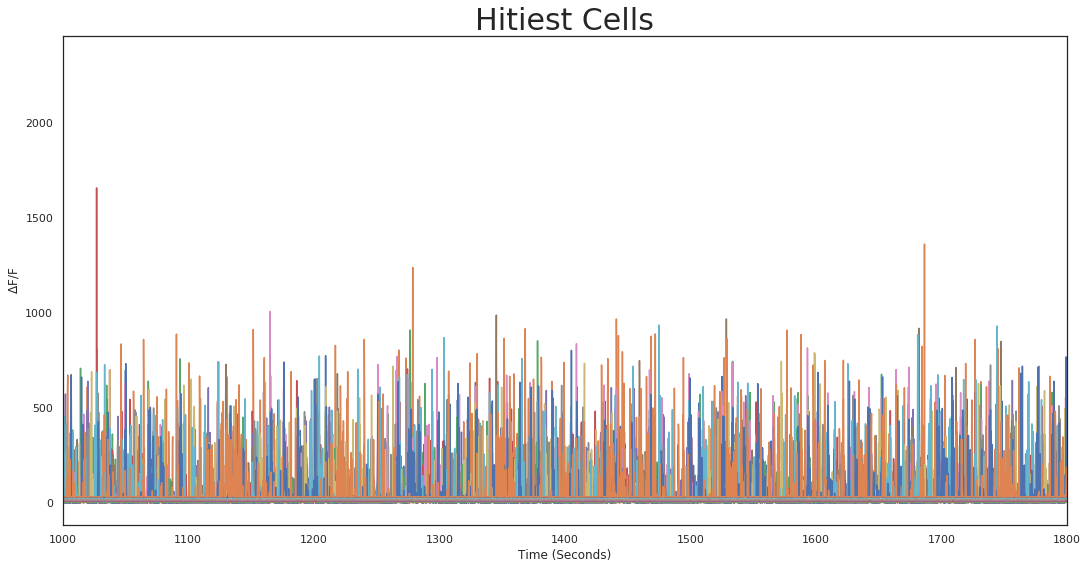

In [24]:
hit_order = np.argsort(all_hits)
hitiest = [get_idx_from_flat(runs, idx) for idx in np.flip(hit_order[-12:])]

plt.figure(figsize=(18,9))
for i, cell in enumerate(hitiest): 
    x_axis = np.arange(runs[cell[0]].flu.shape[1]) / fs
    plt.plot(x_axis, runs[cell[0]].flu[cell[1], :] + i*3)
plt.xlim((1000,1800))
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$\Delta $F/F')
plt.title('Hitiest Cells', fontsize=30)
#sns.despine(left=True)
ax = plt.gca()
#ax.set_yticks([])

In [25]:
to_corr = ['spont', 'hit']
all_spontys , _ = correlation_plots(runs, behaviour_list, pre_frames, post_frames, offset,
                                  to_corr, good=good, is_spks=is_spks, plot=False)


ere


(0, 30)

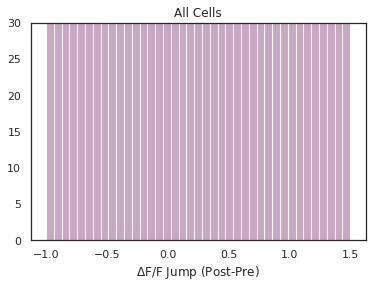

In [28]:
bins = np.linspace(-1,1.5,40)
h = plt.hist(all_licks, bins=bins, label='Spontaneous\nRewards')
h = plt.hist(all_spontys, bins=bins, color='Pink', 
             alpha=0.7,label='Control\n"Trials"')
#plt.legend(bbox_to_anchor=(0.47, 0.8),fontsize=16)
plt.xlabel(r'$\Delta $F/F Jump (Post-Pre)')
plt.title('All Cells')
#plt.xlim((-0.3,0.3))
#plt.xlim((-10,10))
#plt.ylim(0,30)
#plt.xlim((-0.3,0.3))
plt.ylim((0,30))

In [29]:
stats.ks_2samp(all_licks, all_spontys)

Ks_2sampResult(statistic=0.059541294768952646, pvalue=9.461657035258692e-28)

In [30]:
# how many licks on pre_reward vs hit_rewards???
# bin the pre-licks
pre_binnedlicks = []

for run in runs:
    tstarts = run.pre_reward
    pre_licks = run.pre_licks

    for i, tstart in enumerate(tstarts):
        if i == len(tstarts) - 1:
            tend = np.inf
        else:
            tend = tstarts[i+1]

        lick_idx = np.where((run.pre_licks >= tstart) & (run.pre_licks < tend))

        pre_binnedlicks.append(pre_licks[lick_idx])

# the number of licks in each trial
pre_nlicks = np.array([len(binned) for binned in pre_binnedlicks])

In [31]:
# flat list of binned licks
binned_licks = []
for run in runs:
    for trial, outcome in enumerate(run.outcome):
        if outcome=='hit':
            binned_licks.append(run.binned_licks[trial])
    
n_licks = np.array([len(binned) for binned in binned_licks])


([<matplotlib.axis.XTick at 0x7fe616ef1c88>,
 <a list of 2 Text xticklabel objects>)

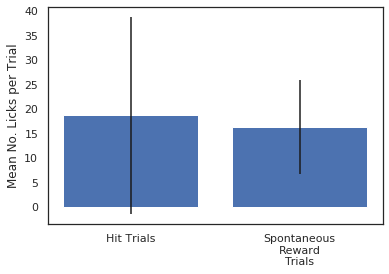

In [32]:
plt.bar([0,1], [n_licks.mean(), pre_nlicks.mean()], yerr=[n_licks.std(), pre_nlicks.std()])
plt.ylabel('Mean No. Licks per Trial')
plt.xticks([0,1],['Hit Trials', 'Spontaneous\nReward\nTrials'])

## lick trial triggered average plot

In [33]:
lick_list = [utils.build_flu_array(run, run.pre_reward,
                                     pre_frames, post_frames, True)
                                     for run in runs]

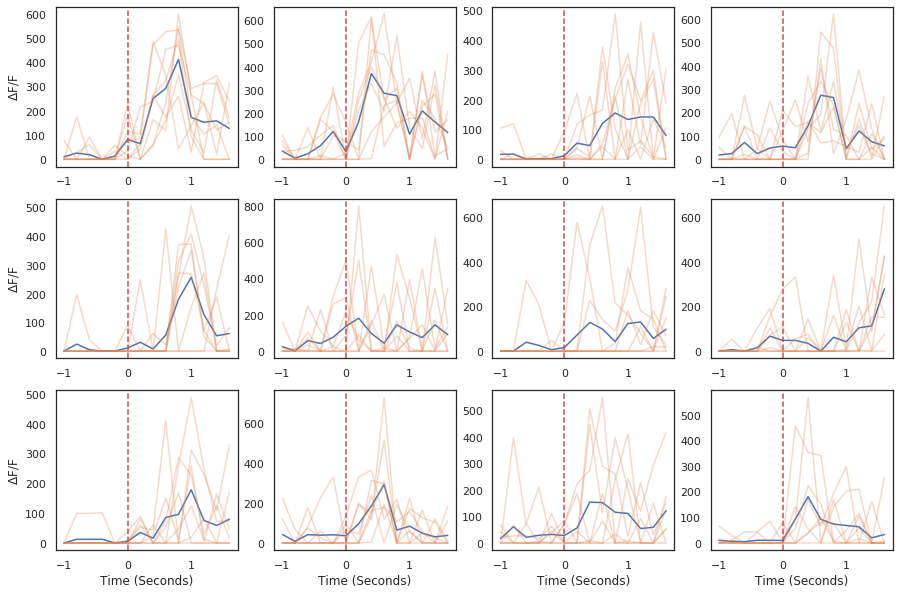

In [34]:

plt.figure(figsize=(15, 10))

n_trials = lick_list[0].shape[1]
x_axis = (np.arange(-pre_frames, post_frames)) / fs
for i, cell in enumerate(lickiest): 
    plt.subplot(3,4,i+1)
    cell_data = lick_list[cell[0]][cell[1], :, :]
    
    plt.plot(x_axis, np.mean(cell_data, 0))

    for t in range(n_trials): 
        plt.plot(x_axis, cell_data[t,:], color=sns.color_palette()[1], alpha=0.3)
        
    plt.axvline(x=0, ls='--', color=sns.color_palette()[3])
    if i in [0,4,8]:
        plt.ylabel(r'$\Delta $F/F')
    if i > 7:
        plt.xlabel('Time (Seconds)')
        

## correlations

In [35]:

cell_info = np.array([get_idx_from_flat(runs, idx) for idx in np.flip(lick_order)])
sessions = cell_info[:,0]
idxs = cell_info[:,1]


# for session in sessions:

session = 0
session_idx = np.where(sessions==session)[0]
cell_idxs = idxs[session_idx]


run = runs[session]
arr = np.zeros(int(np.ceil(max(run.pre_licks)/1000) * 1000))
arr[run.pre_licks] = 1
gauss_convd =  gaussian_filter(arr, sigma=50)*200

In [36]:
pre_idx = np.where(~np.isnan(run.frames_ms_pre[0,:]))[0]
flu = run.flu[:,pre_idx]
flu.shape

print(np.nanmax(run.frames_ms_pre))
print(np.nanmax(run.pre_licks))

84035.14859437753
90406


(70000, 80000)

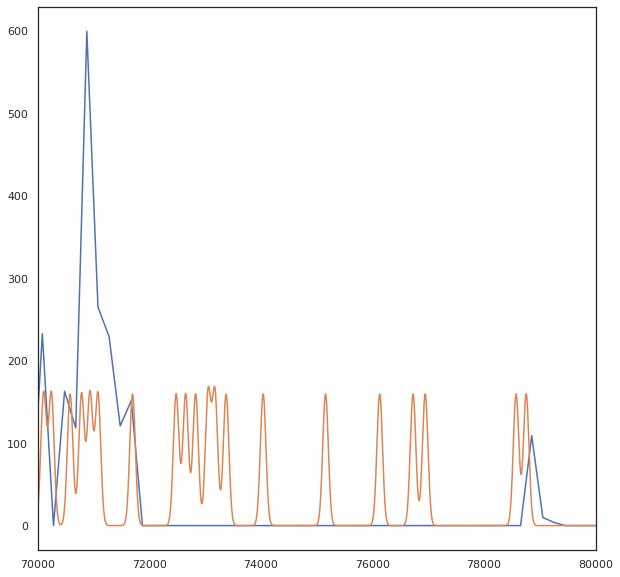

In [37]:
plt.figure(figsize=(10,10))
plt.plot(run.frames_ms_pre[cell_idxs[0], :], run.flu[cell_idxs[0], :])
plt.plot(gauss_convd*100)
plt.xlim((70000,80000))

In [38]:


# n_plots = 8
# plt.figure(figsize=(20,30))
# lw = 3
# for i in range(n_plots):
    
#     plt.subplot(12,1,i+1)
#     cell_idx = cell_idxs[i]
    
#     ax = plt.gca()
#     ax.set_yticks([])
#     sns.despine(left=True, bottom=True)
#     plt.ylim((0,400))
#     plt.xlim((70000,80000))
    
#     if i == n_plots-1:
#         plt.plot(gauss_convd, label='Licks Convolved',
#                  linewidth=lw,color=sns.color_palette()[1])

#         utils.raster_plot(run.pre_licks,markersize=15, 
#                           label='Licks', color=sns.color_palette()[2])
#         plt.ylim((0,1.8))
#         plt.xlabel('Time (ms)')
#         break
        
#     ax.set_xticks([])
#     plt.plot(run.frames_ms_pre[cell_idx, :], run.flu[cell_idx, :], label='Deconvolved Spikes',
#             linewidth=lw, color=sns.color_palette()[0])

    


        

## Corrleations

In [39]:
session = 0
run = runs[session]
n_cells = run.flu.shape[0]

In [40]:
def get_corrs(run, shuffle=False):

    arr = np.zeros(int(np.ceil(max(run.pre_licks)/1000) * 1000))
    arr[run.pre_licks] = 1
    if shuffle:
        random.shuffle(arr)
    gauss_convd =  gaussian_filter(arr, sigma=50)
    
    pre_idx = np.where(~np.isnan(run.frames_ms_pre[0,:]))[0]

    interp_funcs = [interp1d(run.frames_ms_pre[i, pre_idx], run.flu[i, pre_idx], bounds_error=False)
                   for i in range(n_cells)]

    interped_flu = [interp_funcs[i](np.arange(len(gauss_convd))) for i in range(n_cells)]
    interped_flu = np.array(interped_flu)


    # plt.plot(run.frames_ms_pre[1002,:], run.flu[1002,:], '--')
    # plt.plot(interped_flu[1002,:])
    # plt.xlim((1000,10000))

    # find all columns with nans
    nan_idxs = np.isnan(interped_flu)
    nan_cols = np.any(nan_idxs, axis=0)

    interped_flu = interped_flu[:, ~nan_cols]
    gauss_convd = gauss_convd[~nan_cols]
    
    coors = np.corrcoef(gauss_convd, interped_flu)
    # hermitian(ish) matrix so take first col (ignore first entry is = 1)
    corrs = coors[0,1:]
    assert len(corrs) == run.flu.shape[0]
    
    return corrs, interped_flu, gauss_convd

In [59]:
corrs, interped_flu, gauss_convd = get_corrs(run, shuffle=False)
corrs_shuff, _, gauss_convd_shuffled = get_corrs(run, shuffle=True)


Text(0.5, 0, 'Pearsons Corrcoeff with Spks')

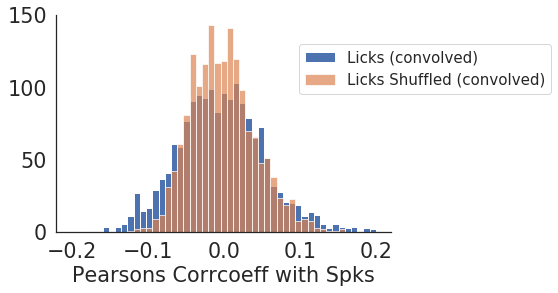

In [66]:
h = plt.hist(corrs, bins=np.linspace(-0.2, 0.2, 50), color=sns.color_palette()[0],
             label='Licks (convolved)')
h2 = plt.hist(corrs_shuff, bins=np.linspace(-0.2, 0.2, 50), color=sns.color_palette()[1], alpha=0.7,
             label='Licks Shuffled (convolved)')
plt.legend(fontsize=15, loc=1, bbox_to_anchor=(1.5,0.9))
plt.xlabel('Pearsons Corrcoeff with Spks')

In [43]:
stats.ks_2samp(corrs, corrs_shuff)

Ks_2sampResult(statistic=0.08023598820058994, pvalue=3.3233999211007005e-05)

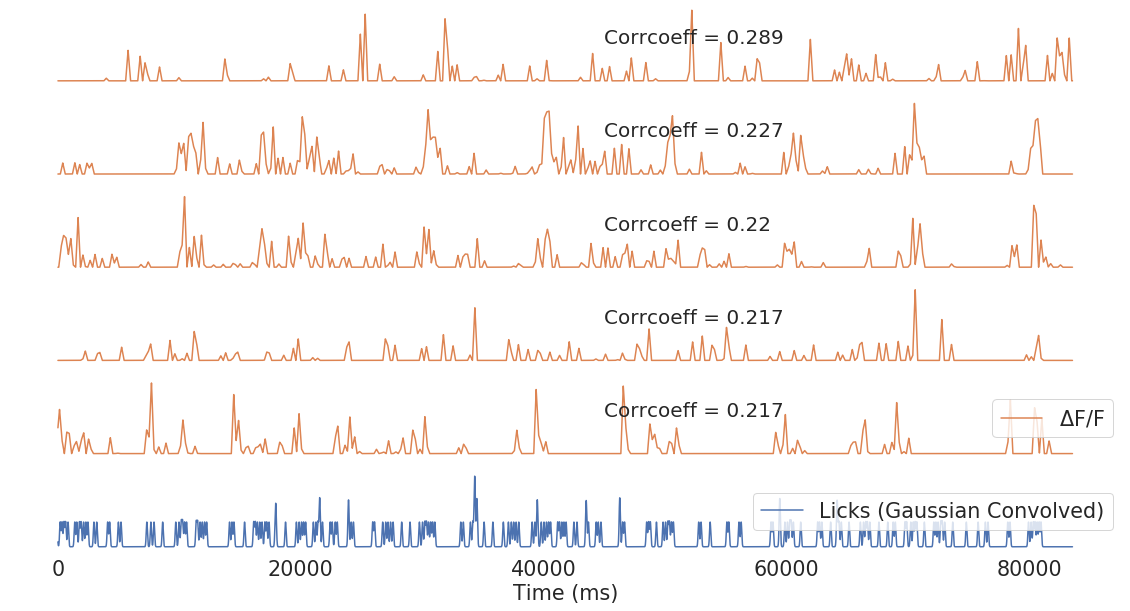

In [67]:
fig = plt.figure(figsize=(20,10))
corr_order = np.argsort(corrs)

n_plots = 6
p = [None]*n_plots
for i in range(n_plots): 
    plt.subplot(n_plots,1, i+1)
    ax = plt.gca()
    sns.despine(bottom=True, left=True)
    ax.set_yticks([])
    
    if i == n_plots-1:
        p[i] = plt.plot(gauss_convd, color=sns.color_palette()[0], label= 'Licks (Gaussian Convolved)')
        plt.xlabel('Time (ms)')
        plt.legend(loc='right')
    else:
        p[i] = plt.plot(interped_flu[corr_order[-i], :], color=sns.color_palette()[1],
                        label= r'$\Delta $F/F')
        ax.set_xticks([])
        plt.text(45000,ax.get_ylim()[1]/2, 'Corrcoeff = {}'.format(round(corrs[corr_order[-i-1]], 3)),
                 fontsize=20)
        
        if i == n_plots-2:
            plt.legend(loc='right')

        


    #plt.xlim((30000,50000))   

In [68]:
#x = normalize(interped_flu)
x = interped_flu
# gauss_convd
ica = FastICA(whiten=True, n_components=15)
s = ica.fit(x)
comps = s.components_
s.__dict__.keys()

dict_keys(['n_components', 'algorithm', 'whiten', 'fun', 'fun_args', 'max_iter', 'tol', 'w_init', 'random_state', 'n_iter_', 'components_', 'mean_', 'whitening_', 'mixing_'])

In [71]:
corrs = np.corrcoef(gauss_convd, comps)
corrs_shuffled = np.corrcoef(gauss_convd_shuffled, comps)
# hermitian(ish) matrix so take first col (ignore first entry is = 1)
corrs = corrs[0,1:]
corrs_shuffled = corrs_shuffled[0,1:]

In [74]:
np.argsort(corrs)

array([10,  8,  0, 13, 12,  6,  2, 11,  1,  9, 14,  4,  3,  7,  5])

Text(0, 0.5, 'Pearsons corcoeff')

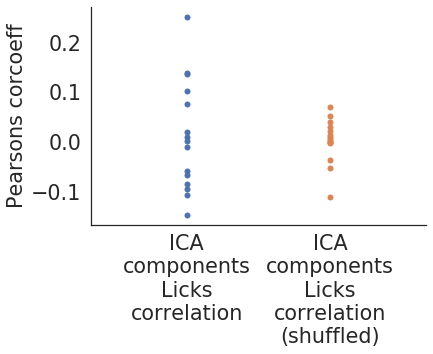

In [73]:
plt.plot(np.zeros(len(corrs)), corrs, '.', markersize=10)
plt.plot(np.ones(len(corrs_shuffled))*1.5, corrs_shuffled, '.', markersize=10)
plt.xlim((-1, 2.5))
#ax = plt.gca()
plt.xticks([0,1.5], ['ICA\ncomponents\nLicks\ncorrelation',
                   'ICA\ncomponents\nLicks\ncorrelation\n(shuffled)'])
plt.ylabel('Pearsons corcoeff')

Text(0.5, 0, 'Pearsons Corrcoeff')

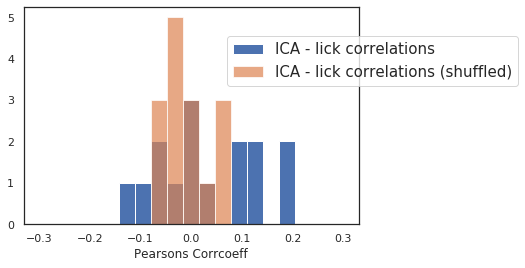

In [49]:
n_bins = 20
h = plt.hist(corrs, bins=np.linspace(-0.3, 0.3, n_bins), color=sns.color_palette()[0],
             label='ICA - lick correlations')
h2 = plt.hist(corrs_shuffled, bins=np.linspace(-0.3, 0.3, n_bins), color=sns.color_palette()[1], alpha=0.7,
             label='ICA - lick correlations (shuffled)')
plt.legend(fontsize=15, loc=1, bbox_to_anchor=(1.5,0.9))
plt.xlabel('Pearsons Corrcoeff')

In [75]:
ica_comp = 5

(50000, 80000)

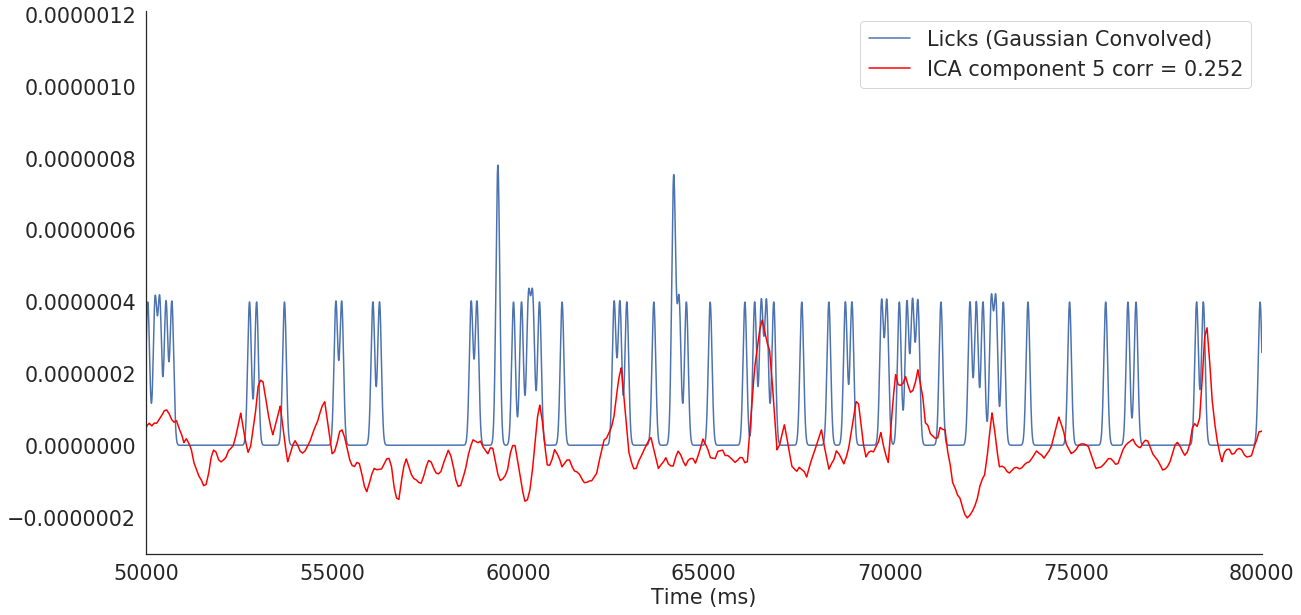

In [89]:
plt.figure(figsize=(20,10))

plt.plot(gauss_convd/20000, label='Licks (Gaussian Convolved)')
plt.plot(comps[ica_comp,:], color='red', label='ICA component {} corr = {}'
         .format(ica_comp, round(corrs[ica_comp], 3)))
plt.legend()
plt.xlabel('Time (ms)')
#plt.ylim((-0.5e-7,2e-7))
#plt.plot(x[cell_idxs[0],:], alpha=0.5)
plt.xlim((50000,80000))

In [52]:
1/0

ZeroDivisionError: division by zero

## Perform linear subtraction

In [ ]:
hit_list = [np.where(run.outcome=='hit')[0] for run in runs]

subtraction_res = [rf.subtract_kernal(behaviour_list[session], runs[session], 
                                  hit_list[session], rf.get_time_to_lick(runs[session]),
                                  pre_frames=pre_frames, post_frames=post_frames) 
                   for session in range(n_sessions)]

#behaviour_list =  [res[0] for res in subtraction_res]
print('Warning: disabled subtraction')
cell_licky_idxs = [res[1] for res in subtraction_res]
licky_pre_posts = [res[2] for res in subtraction_res]

In [ ]:
# some examples of subtraction
session_idx = 0
flu_array = copy.deepcopy(behaviour_list[session_idx])
run = copy.deepcopy(runs[session_idx])

intersect = lambda lst1, lst2: list(set(lst1) & set(lst2)) 
hit_trials = copy.deepcopy(hit_list[session_idx])
sub_trials = np.where(Subsets(run).trial_subsets==50)[0]

# sub_trials = hit_trials
trials_to_sub = intersect(hit_trials, sub_trials)
offset_sub = rf.get_time_to_lick(run)

subtraction_res = rf.subtract_kernal(flu_array, run, trials_to_sub, offset_sub, pre_frames=pre_frames,
                                  post_frames=post_frames, plot=True)

## Misc plots

In [ ]:
run = runs[session_idx]
plt.figure(figsize=(18,9))
for i, cell in enumerate(cell_licky_idxs[session_idx][:12]): 
    plt.plot(run.flu[cell, :] + i*5)
#plt.xlim((0,2000))

In [ ]:
# # plot the average traces for go trials without easy stim
# test_filter = [np.where((Subsets(run).trial_subsets != 150)&(Subsets(run).trial_subsets!=0))[0]
#                for run in runs]

# _,_,_,_ = utils.averager(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
#                  trial_filter=test_filter, offset=offset, plot=True)

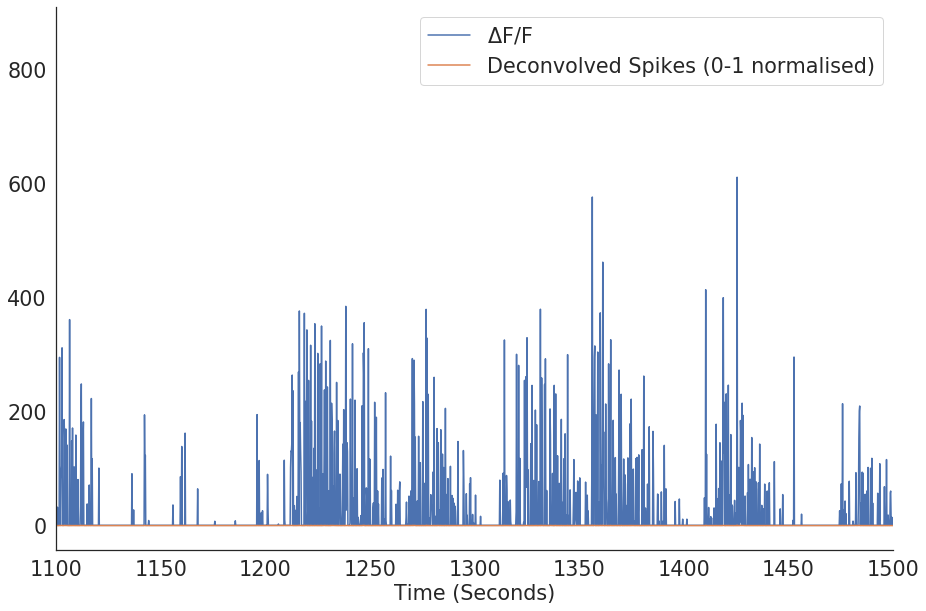

In [90]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

session = 0
cell_idx = 1
fs = 5
x_axis = np.arange(runs[session].flu.shape[1]) / fs
plt.figure(figsize=(15,10))
plt.plot(x_axis, runs[session].flu[cell_idx, :]+0.5,
        label='$\Delta $F/F')
plt.plot(x_axis, NormalizeData(runs[session].spks[cell_idx, :]),
         label='Deconvolved Spikes (0-1 normalised)')
plt.xlim((1100,1500))
plt.xlabel('Time (Seconds)')
plt.legend()

## Lick trial classification using LSTMs

In [ ]:
## subtraction of the pre-reward trials for classifier

lick_kernals = [utils.build_flu_array(run, run.pre_reward, pre_frames, post_frames, True)
                for run in runs]

subtraction_res = [subtract_kernal(lick_kernals[session], runs[session],
                                  pre_frames=pre_frames, post_frames=post_frames) 
                   for session in range(n_sessions)]

lick_kernals_subbed = [res[0] for res in subtraction_res]

In [ ]:
def build_session_array(list_, filter_list=None, n_filtered_cells=None):
    
    ''' builds a tbt flu array across sessions from list of inidivudual sessions
        Returns:
        session_array -- [min cells x total trials x frames in trial]
    
        '''
    min_cells = min([s.shape[0] for s in list_])
    
    if filter_list:
        assert len(filter_list) == len(list_) and n_filtered_cells != None\
        and n_filtered_cells <= min_cells

    for i, arr in enumerate(list_):
        if filter_list:
            cell_idxs = filter_list[i][0:n_filtered_cells]
        else:     
            # randomly subsample cells
            cell_idxs = np.random.choice(np.arange(0,arr.shape[0]), min_cells)
        if i == 0:
            session_array = arr[cell_idxs, :, :]
        else:
            session_array = np.hstack((session_array, arr[cell_idxs, : ,:]))

    return session_array

In [ ]:
def get_LSTM(data_shape):
    
    model = Sequential()
    model.add(LSTM(256, input_shape=(data_shape[1], data_shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    adam = Adam(lr=0.001)

    model.my_checkpoints = ModelCheckpoint('best_model.pkl', monitor='val_acc', 
                                            save_best_only=True, mode='max', verbose=1)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [ ]:
def cv_classifier(arr1, arr2, fold=10, shuffle=False):
    
    assert arr1.shape == arr2.shape
    
    nonnan_trials = lambda arr: ~np.isnan(arr).any(axis=0).any(axis=1)
    nonnan_idx = np.logical_and(nonnan_trials(arr1), nonnan_trials(arr2))
    
    arr1 = arr1[:,nonnan_idx,:]
    arr2 = arr2[:,nonnan_idx,:]
    
    data = np.hstack((arr1, arr2))
    # switch from [n_cells x n_trials x n_frames] to [n_features x n_samples x n_observers]
    data = np.swapaxes(data, 0, 1)   
    
    if shuffle: np.random.shuffle(data)
        
    labels = np.hstack((np.repeat(1, data.shape[0] / 2), np.repeat(0, data.shape[0] / 2)))
    
    kf = ShuffleSplit(n_splits=fold, test_size=0.2)
    test_accs = []
    fold_count = 0
    for train_idx, testvalid_idx in kf.split(data):
        
        half = math.floor(len(testvalid_idx)/2)
        valid_idx = testvalid_idx[:half]
        test_idx = testvalid_idx[half:]
        
        model = get_LSTM(data.shape)
        
        model.fit(data[train_idx], labels[train_idx], epochs=150, batch_size=128, 
                  callbacks=[model.my_checkpoints], 
                  validation_data=(data[valid_idx],labels[valid_idx]),
                  verbose=False)

        test_preds = model.predict_classes(data[test_idx])
        test_accuracy = accuracy_score(labels[test_idx], test_preds)
        print('Test Accuracy is {}'.format(test_accuracy))
        test_accs.append(test_accuracy)
        
        fold_count += 1
        print(fold_count)
        
    return test_accs

In [ ]:
n_cells_keep = 500
spont_list = [get_spont_trials(run) for run in runs]
spont_list2 = [get_spont_trials(run) for run in runs]

spont_arr = build_session_array(spont_list, cell_licky_idxs, n_filtered_cells=n_cells_keep)
spont_arr2 = build_session_array(spont_list2, cell_licky_idxs, n_filtered_cells=n_cells_keep)
lick_arr = build_session_array(lick_kernals, cell_licky_idxs,  n_filtered_cells=n_cells_keep)
lick_arr_subbed = build_session_array(lick_kernals_subbed, cell_licky_idxs,  n_filtered_cells=n_cells_keep)

In [ ]:
test_accs = cv_classifier(lick_arr, spont_arr)
print(np.mean(test_accs))
print(np.std(test_accs))

In [ ]:
test_accs2 = cv_classifier(spont_arr2, spont_arr)
print(np.mean(test_accs2))
print(np.std(test_accs2))

In [ ]:
test_accs3 = cv_classifier(lick_arr, spont_arr, shuffle=True)
print(np.mean(test_accs3))
print(np.std(test_accs3))

In [ ]:
test_accs4 = cv_classifier(lick_arr_subbed, spont_arr, shuffle=False)
print(np.mean(test_accs4))
print(np.std(test_accs4))

In [ ]:
x=np.arange(4)
y = [np.mean(d) for d in [test_accs, test_accs4, test_accs2, test_accs3]]
yerr = [np.std(d) for d in [test_accs, test_accs4, test_accs2, test_accs3]]

In [ ]:
plt.bar(x=x+0.4,height=y,yerr=yerr)

xt = plt.xticks(x, 
                [
                    'Lick vs\nSpontaneous',
                    'Lick Subtracted vs\nSpontaneous',
                    'Spontaneous vs\nSpontaneous',
                    'Lick vs\nSpontaneous Shuffled'
                                                    ],
                rotation=60)
plt.ylabel('Classifier Performance\nChance=0.5')


In [ ]:
runs[0].flu.shape

### SVC lick classification
#### Doesn't make sense to do this as observations are not independent

In [ ]:
def split_dataset(dataset, split=0.8, shuffle=True):
    x,y = dataset
    assert x.shape[0] == y.shape[0]
    n_trials = x.shape[0]
    subset = int(split*n_trials)
    idx = np.arange(n_trials)
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:subset]
    x_valid = x[subset:]
    y_train = y[:subset]
    y_valid = y[subset:]
    return (x_train, y_train),(x_valid, y_valid)

In [ ]:
def split_dataset3d(dataset, split=0.8, shuffle=True):
    x,y = dataset
    assert x.shape[1] == y.shape[0]
    n_trials = x.shape[1]
    subset = int(split*n_trials)
    idx = np.arange(n_trials)
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:subset]
    x_valid = x[subset:]
    y_train = y[:subset]
    y_valid = y[subset:]
    return (x_train, y_train),(x_valid, y_valid)

In [ ]:
def split_dataset(dataset, split=0.8, shuffle=True):
    x,y = dataset
    assert x.shape[0] == y.shape[0]
    n_trials = x.shape[0]
    idx = np.arange(n_trials)
    n_trials_train = int(len(idx) * split)
    n_trials_valid = math.ceil((n_trials - n_trials_train) / 2)
    n_trials_test = math.floor((n_trials - n_trials_train)  / 2)

    if shuffle: np.random.shuffle(idx)
    idx_train = idx[:n_trials_train]
    idx_valid = idx[n_trials_train:n_trials_train+n_trials_valid]
    idx_test  = idx[n_trials_train+n_trials_valid:]
    
    return (x[idx_train], y[idx_train]), (x[idx_valid], y[idx_valid]), (x[idx_test], y[idx_test])

In [ ]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [ ]:
## cell builds dataset for classifier that is trial averaged

spont_list = [get_spont_trials(run) for run in runs]
spont_list2 = [get_spont_trials(run) for run in runs]
# the number of cells from each session to insert into the array

spont_arr = build_session_array(spont_list, cell_licky_idxs, n_filtered_cells=n_cells_keep)
lick_arr = build_session_array(spont_list2, cell_licky_idxs, n_filtered_cells=n_cells_keep)
#lick_arr = build_session_array(lick_kernals_subbed, cell_licky_idxs,  n_filtered_cells=n_cells_keep)


assert spont_arr.shape == lick_arr.shape

nonnan_idx = ~np.isnan(lick_arr).any(axis=0).any(axis=1)

lick_arr = lick_arr[:,nonnan_idx,:]
spont_arr = spont_arr[:,nonnan_idx,:]

# mean across trials
spont = np.mean(spont_arr, 1)
lick = np.mean(lick_arr, 1)
all_arr = np.hstack((lick, spont)).T
labels = np.hstack((np.repeat(1, all_arr.shape[0] / 2), np.repeat(0, all_arr.shape[0] / 2)))

In [ ]:
training_accs = []
test_accs = []
cvs = []

n_cells_list = np.arange(10,500,10)

for n_cells in n_cells_list:
    x = all_arr[:,0:n_cells]

    dataset = (x, labels)
    
    trainset, validset = split_dataset(dataset)
    scaler = StandardScaler()
    trainset = scaler.fit_transform(trainset[0]), trainset[1]
    validset = scaler.fit_transform(validset[0]), validset[1]
     
    clf = SVC(kernel='poly', C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=3)
    cvs.append(scores.mean())


In [ ]:
plt.plot(n_cells_list, cvs)
plt.xlim((0,200))
plt.xlabel('Number of cells shown to classifier')
plt.ylabel('Classifier Accuracy')
plt.title('Spontaneous vs Spontanous')

In [ ]:
# confusion matrix for the final iteration of the above loop

svc = SVC(kernel='poly')
svc.fit(*trainset)
y_true=validset[1]
y_pred=svc.predict(validset[0])
M=confusion_matrix(y_true, y_pred)
plt.imshow(M)
plt.title("Confusion matrix")
plt.colorbar()

In [ ]:
import scipy.io as sio
sio.savemat('flu.mat', {'flu':runs[0].flu})